In [1]:
import warnings
warnings.filterwarnings('ignore')

### Wczytanie pakietów

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PowerTransformer
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from ucimlrepo import fetch_ucirepo
from sklearn.metrics import balanced_accuracy_score
import copy
from sklearn.datasets import fetch_openml
from numpy.linalg import inv
#from sklearn.datasets import fetch_openml

### Klasa obiektowa

In [3]:
class LogisticRegression:
    def __init__(self):
        pass
    def fit_IWLS(self, X, y, epoch = 500):
        self.X = self.transform_X(X)
        self.y = self.transform_y(y)
        self.N,self.P = self.X.shape
        self.optimize(epoch = 500)
    
    def fit_gradient_descent(self, X, y, eta = 0.5, eps = 0.00001, epochs = 500):
        self.X = self.transform_X(X)
        self.y = self.transform_y(y)
        self.N,self.P = self.X.shape
        self.g_descent(eta = 0.5, eps = 0.00001, epochs = 500)
        
    def fit_stochastic_gradient_descent(self, X, y, eta = 0.5, eps = 0.00001, epochs = 500):
        self.X = self.transform_X(X)
        self.y = self.transform_y(y)
        self.N,self.P = self.X.shape
        self.stoch_g_descent(eta = 0.5, eps = 0.00001, epochs = 500)
    
    def fit_batch_stochastic_gradient_descent(self, X, y, eta = 0.5, eps = 0.00001, epochs = 500, batch = 20):
        self.X = self.transform_X(X)
        self.y = self.transform_y(y)
        self.N,self.P = self.X.shape
        self.batch_descent(eta = 0.5, eps = 0.00001, epochs = 500, batch = 20)
    

    def optimize(self, epoch = 500):

        # wektor początkowy dla bet
        betas = np.zeros((self.P,1))

        # wektor do zapisywania funkcji straty
        losses = []
        for e in range(epoch):
            y_hat = self.sigmoid(np.matmul(self.X, betas))
            W = np.diag(np.ravel(y_hat*(1-y_hat)))
            grad = np.matmul(self.X.T, (y_hat-self.y))
            hessian = np.matmul(np.matmul(self.X.T, W), self.X) + 0.001*np.eye(self.P)
            betas -= np.matmul(inv(hessian), grad)

            loss = self.cross_entropy_loss(self.y, self.sigmoid(np.matmul(self.X, betas)))
            losses.append(loss)

        self.coef = betas[1:]
        self.intercept = betas[0]
        self.losses = losses
    
    def g_descent(self, eta = 0.5, eps = 0.00001, epochs = 500):
    
        num = 0
        betas = np.zeros((self.P,1))
        losses_gd = []
        for i in range(epochs):
            y_pred = self.sigmoid(np.matmul(self.X, betas))
            losses_gd.append(self.cross_entropy_loss(self.y, self.sigmoid(np.matmul(self.X, betas))))
            #res = y_pred - self.y
            #gradient = np.matmul(res, self.X) 
            gradient = np.matmul(self.X.T, (y_pred-self.y))
            betas = betas - eta * gradient
            if i > 1:
                if abs(losses_gd[i] - losses_gd[i-1]) < eps:
                    num += 1
                else:
                    num = 0
                if  num > 10:
                    break
                    
        self.coef = betas[1:]
        self.intercept = betas[0]
        self.losses = losses_gd
    
    
    def stoch_g_descent(self, eta = 0.5, eps = 0.00001, epochs = 500):
    
        betas = np.zeros((self.P,1))
        losses_sgd = []
        num = 0
        for i in range(epochs):
            for index in range(self.N):
                y_pred = self.sigmoid(np.matmul(self.X, betas))
                gradient = self.X[[index]].T * (y_pred - self.y)[index]
                #gradient = np.matmul(self.X.T[index], (y_pred-self.y)[index])
                betas = betas - eta * gradient
            losses_sgd.append(self.cross_entropy_loss(self.y, self.sigmoid(np.matmul(self.X, betas))))
            if i > 1:
                if abs(losses_sgd[i] - losses_sgd[i-1]) < eps:
                    num += 1
                else:
                    num = 0
                if  num > 10:
                    break
        self.coef = betas[1:]
        self.intercept = betas[0]
        self.losses = losses_sgd
        
        
    def batch_descent(self, eta = 0.5, eps = 0.00001, epochs = 500, batch = 20):
    
        betas = np.ones((self.P,1))
        losses_batch = []
        num = 0
        for i in range(epochs):
            for index in range(0, self.N, batch):
                sup = index + batch
                if sup > self.N:
                    sup = self.N
                y_pred = self.sigmoid(np.matmul(self.X, betas))
                gradient = np.matmul(self.X[index:sup].T ,(y_pred - self.y)[index:sup])
                #gradient = np.matmul(self.X.T[index], (y_pred-self.y)[index])
                betas = betas - eta * gradient
            losses_batch.append(self.cross_entropy_loss(self.y, self.sigmoid(np.matmul(self.X, betas))))
            if i > 1:
                if abs(losses_batch[i] - losses_batch[i-1]) < eps:
                    num += 1
                else:
                    num = 0
                if  num > 10:
                    break
        self.coef = betas[1:]
        self.intercept = betas[0]
        self.losses = losses_batch
        
    def predict(self, X, thres=0.5):
        X = np.array(X)
        y_pred= self.sigmoid(np.matmul(X,self.coef) + self.intercept)
        return np.where(y_pred > thres, 1, 0)
        
    def predict_proba(self, X):
        X = np.array(X)
        return self.sigmoid(np.matmul(X,self.coef) + self.intercept)
    
    def transform_X(self, X):
        X = np.array(X)
        X = np.insert(X, 0, np.ones((X.shape[0])), axis = 1)
        return X
    
    def transform_y(self, y):
        y = np.array(y)
        y = y.reshape((y.shape[0], -1))
        return y

    def cross_entropy_loss(self, y_true, y_pred, clip_val = 1e-10):
        y_pred = np.clip(y_pred, clip_val, 1 -clip_val)
        loss = np.multiply(y_true, np.log(y_pred))
        total_loss = -np.sum(loss, axis = 0)
        return total_loss

    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

In [4]:
Model_base = LogisticRegression()

### Funkcje

In [5]:
def gradient(X_train, y_train, X_test, y_test, id, nr_zbioru):
    model = copy.deepcopy(Model_base)
    #model = LogisticRegression()
    model.fit_gradient_descent(X_train, y_train)
    y_pred = model.predict(X_test)
    result = balanced_accuracy_score(y_test, y_pred)
    #plt.subplot(1, 5, id)
    #plt.figure(figsize=(10, 4))
    plt.plot(model.losses)
    plt.xlabel('Iteracje')
    plt.ylabel('Wartość')
    plt.title(f'Funkcja straty gd_{id}')
    plt.savefig(f'Gradient_descent{id}_{nr_zbioru}.png')
#     plt.subplot(2, 5, id)
#     plt.plot(model.losses[1:30])
#     plt.xlabel('Iteracje')
#     plt.ylabel('Wartość')
#     plt.title('Funkcja straty - pierwsze 30')
#     plt.savefig(f'Gradient_descent_first10_{id}.png')
    return result

def stochastic_gradient(X_train, y_train, X_test, y_test, id, nr_zbioru):
    model = copy.deepcopy(Model_base)
    model.fit_stochastic_gradient_descent(X_train, y_train)
    y_pred = model.predict(X_test)
    result = balanced_accuracy_score(y_test, y_pred)
    #plt.figure(figsize=(10, 4))
    plt.plot(model.losses)
    plt.xlabel('Iteracje')
    plt.ylabel('Wartość')
    plt.title(f'Funkcja straty sgd_{id}')
    plt.savefig(f'Stoch_gradient_descent{id}_{nr_zbioru}.png')
    
    return result

def batch_stochastic_gradient(X_train, y_train, X_test, y_test, id, nr_zbioru):
    model = copy.deepcopy(Model_base)
    model.fit_batch_stochastic_gradient_descent(X_train, y_train)
    y_pred = model.predict(X_test)
    result = balanced_accuracy_score(y_test, y_pred)
    #plt.figure(figsize=(10, 4))
    plt.plot(model.losses)
    plt.xlabel('Iteracje')
    plt.ylabel('Wartość')
    plt.title(f'Funkcja straty batch_{id}')
    plt.savefig(f'Batch_gradient{id}_{nr_zbioru}.png')
    
    return result

def IWLS_gradient(X_train, y_train, X_test, y_test, id, nr_zbioru):
    model = copy.deepcopy(Model_base)
    model.fit_IWLS(X_train, y_train)
    y_pred = model.predict(X_test)
    result = balanced_accuracy_score(y_test, y_pred)
    #plt.figure(figsize=(10, 4))
    plt.plot(model.losses)
    plt.xlabel('Iteracje')
    plt.ylabel('Wartość')
    plt.title(f'Funkcja straty iwls_{id}')
    plt.savefig(f'IWLS_gradient{id}_{nr_zbioru}.png')
    
    return result

### Funkcje stała ucząca vs accuracy

In [6]:
def gradient_eta(X_train, y_train, X_test, y_test, id, nr_zbioru, eta):
    
    tmp = []
    for i in eta:
        model = copy.deepcopy(Model_base)
        model.fit_gradient_descent(X_train, y_train, eta=i, epochs=20)
        y_pred = model.predict(X_test)
        result = balanced_accuracy_score(y_test, y_pred)
        tmp.append(result)
    plt.scatter(eta, tmp)
    plt.xlabel('Stała ucząca')
    plt.ylabel('Accuracy')
    plt.title(f'Gd_{id}')
    plt.savefig(f'G_descent{id}_{nr_zbioru}_ETA.png')

def stochastic_gradient_eta(X_train, y_train, X_test, y_test, id, nr_zbioru, eta):
   
    tmp = []
    for i in eta:
        model = copy.deepcopy(Model_base)
        model.fit_stochastic_gradient_descent(X_train, y_train, eta=i, epochs=20)
        y_pred = model.predict(X_test)
        result = balanced_accuracy_score(y_test, y_pred)
        tmp.append(result)
    plt.scatter(eta, tmp)
    plt.xlabel('Stała ucząca')
    plt.ylabel('Accuracy')
    plt.title(f'Sgd_{id}')
    plt.savefig(f'Sg_descent{id}_{nr_zbioru}_ETA.png')

def batch_stochastic_gradient_eta(X_train, y_train, X_test, y_test, id, nr_zbioru, eta):
    
    tmp = []
    for i in eta:
        model = copy.deepcopy(Model_base)
        model.fit_batch_stochastic_gradient_descent(X_train, y_train, eta=i, epochs=20)
        y_pred = model.predict(X_test)
        result = balanced_accuracy_score(y_test, y_pred)
        tmp.append(result)
    plt.scatter(eta, tmp)
    plt.xlabel('Stała ucząca')
    plt.ylabel('Accuracy')
    plt.title(f'Batch_{id}')
    plt.savefig(f'Batch_descent{id}_{nr_zbioru}_ETA.png')
    
    
# def IWLS_gradient_eta(X_train, y_train, X_test, y_test, id, nr_zbioru, eta):
    
#     tmp = []
#     for i in eta:
#         model = copy.deepcopy(Model_base)
#         model.fit_IWLS(X_train, y_train, eta=i, epochs=20)
#         y_pred = model.predict(X_test)
#         result = balanced_accuracy_score(y_test, y_pred)
#         tmp.append(result)
#     plt.plot(eta, tmp)
#     plt.xlabel('Stała ucząca')
#     plt.ylabel('Accuracy')
#     plt.title(f'IWLS_{id}')
#     plt.savefig(f'IWLS_descent{id}_{nr_zbioru}_ETA.png')

### Zbiór danych nr 1

In [7]:
yeast = fetch_ucirepo(id=110) 

X_1 = yeast.data.features.values
y_1 = yeast.data.targets
y_1 = y_1.values
y_1 = np.array([1 if znak == 'MIT' else 0 for znak in y_1])

In [8]:
X_1 = pd.DataFrame(X_1)
print(X_1.isna().sum())
corr_matrix = X_1.corr().abs()
sol = (corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
                  .stack()
                  .sort_values(ascending=False))
print(sol[0:3])
X_1 = X_1.values

0    0
1    0
2    0
3    0
4    0
5    0
6    0
7    0
dtype: int64
0  1    0.581631
1  2    0.271800
2  6    0.185805
dtype: float64


[0.7483953258722844, 0.7618910467412772, 0.7582290980908493, 0.7694206714944042, 0.7563844086021505]
[0.6083360763660303, 0.5551761026991442, 0.5721691902567478, 0.6717001316655695, 0.5719086021505376]
[0.6717001316655695, 0.508187952600395, 0.4924292297564187, 0.7229674127715602, 0.5735887096774194]
[0.6449967083607637, 0.7023123765635286, 0.6327764976958525, 0.6919848584595129, 0.646505376344086]


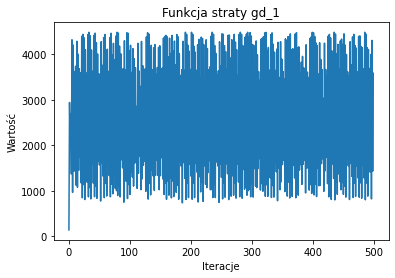

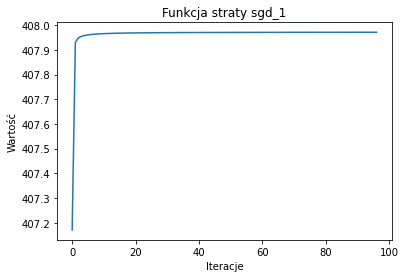

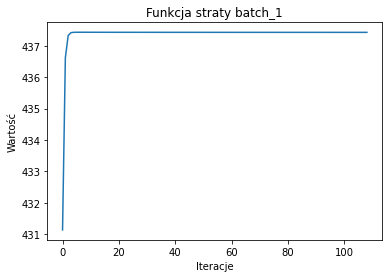

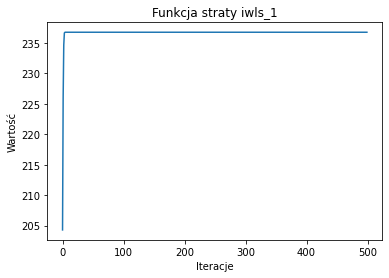

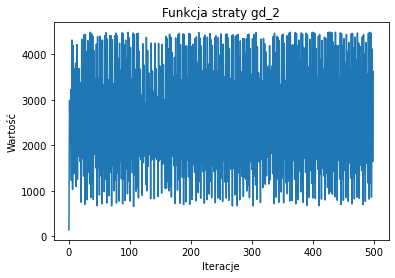

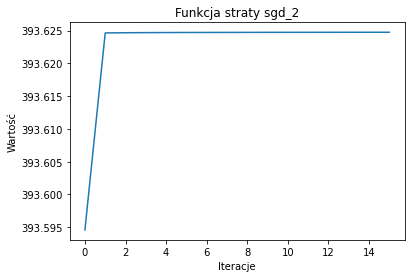

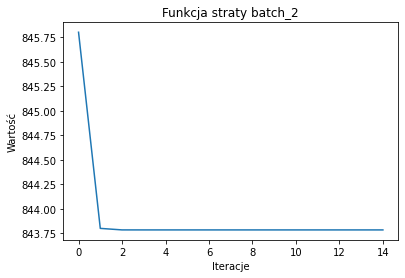

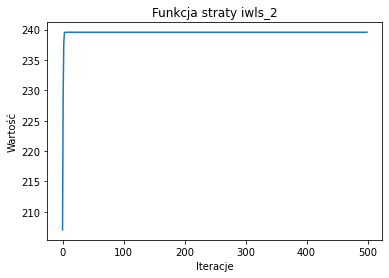

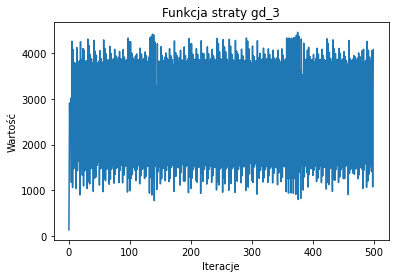

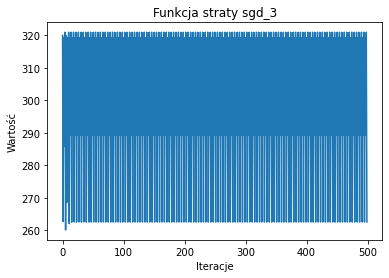

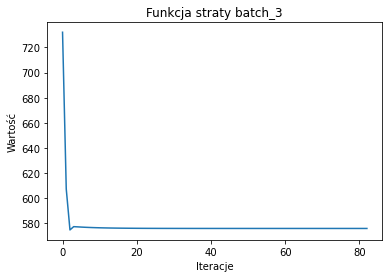

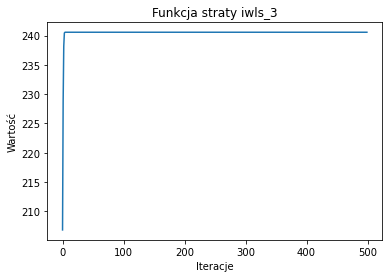

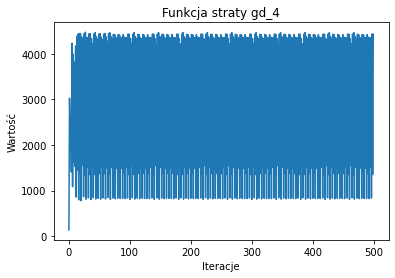

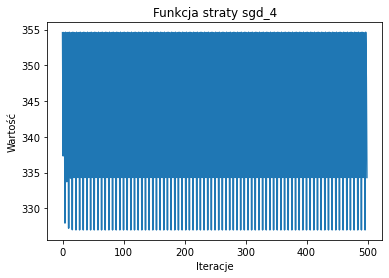

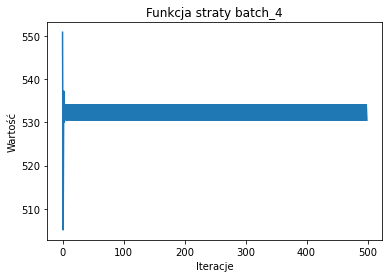

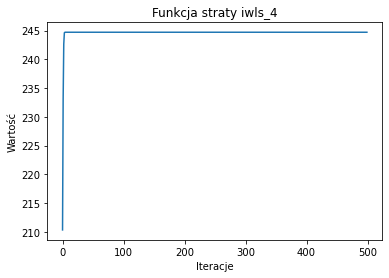

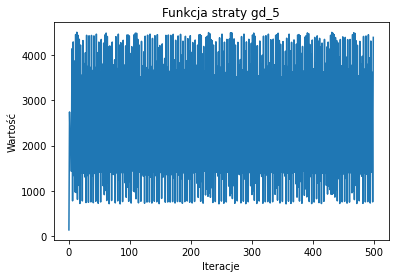

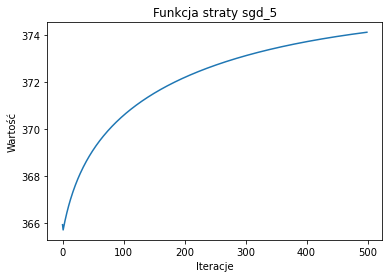

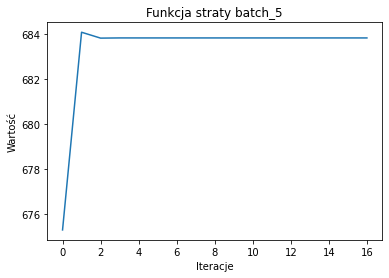

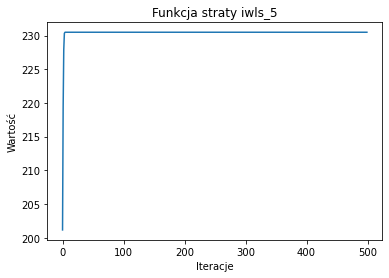

In [15]:
# kroswalidacja 5-cio krotna, gradient descent
skf = StratifiedKFold(n_splits=5, shuffle=True)
id = 1
accuracy_gd_1 = []
accuracy_sgd_1 = []
accuracy_batch_1 = []
accuracy_iwls_1 = []
#plt.figure(figsize=(15, 5))
for train_index, test_index in skf.split(X_1, y_1):
    X_train, X_test = X_1[train_index], X_1[test_index]
    y_train, y_test = y_1[train_index], y_1[test_index]
    
    SC = StandardScaler()
    X_train = SC.fit_transform(X_train)
    X_test = SC.transform(X_test)
    
    # mamy dane po preprocesingu, dla kazdej pary train, test liczymy dokladnosc, tworzymy wykres strata od iteracji
    plt.figure()
    res1 = gradient(X_train, y_train, X_test, y_test, id, nr_zbioru = 1)
    accuracy_gd_1.append(res1)
    plt.figure()
    res2 = stochastic_gradient(X_train, y_train, X_test, y_test, id, nr_zbioru = 1)
    accuracy_sgd_1.append(res2)
    plt.figure()
    res3 = batch_stochastic_gradient(X_train, y_train, X_test, y_test, id, nr_zbioru = 1)
    accuracy_batch_1.append(res3)
    plt.figure()
    res4 = IWLS_gradient(X_train, y_train, X_test, y_test, id, nr_zbioru = 1)
    accuracy_iwls_1.append(res4)
    
    id += 1
print(accuracy_gd_1)
print(accuracy_sgd_1)
print(accuracy_batch_1)
print(accuracy_iwls_1)

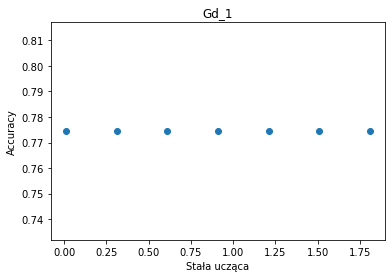

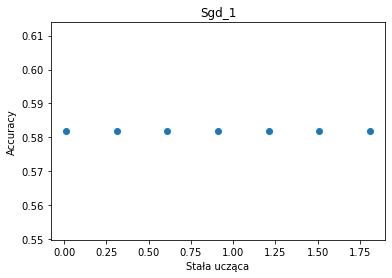

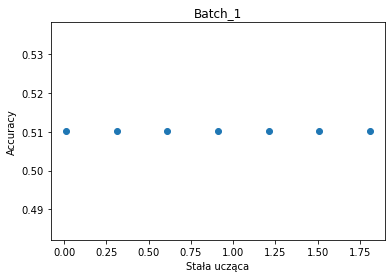

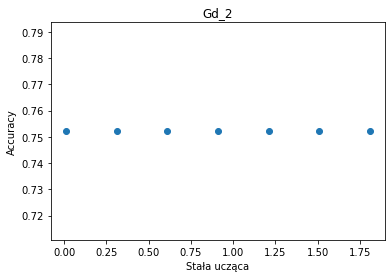

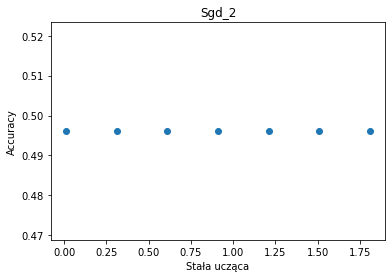

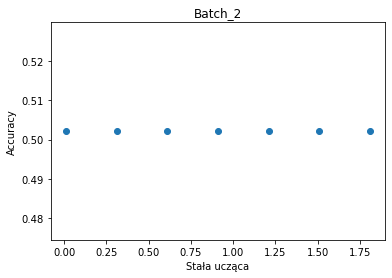

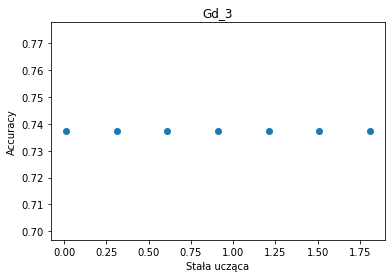

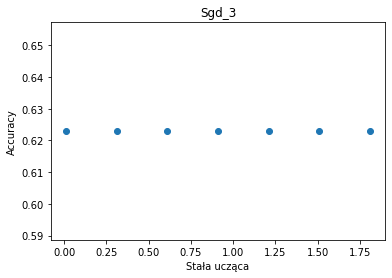

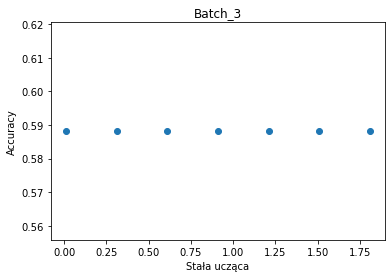

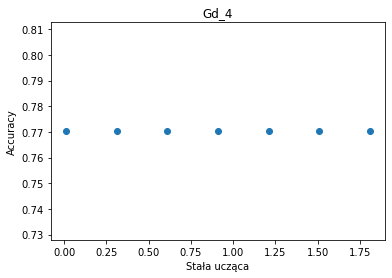

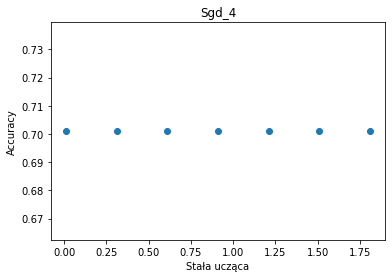

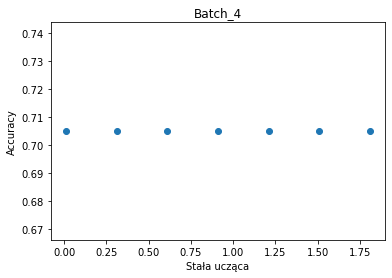

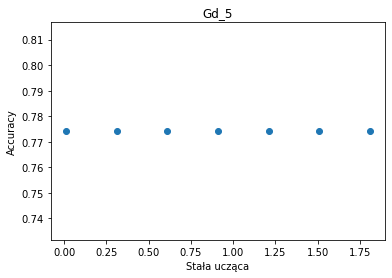

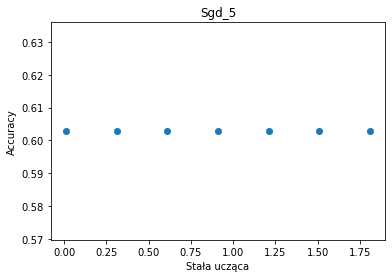

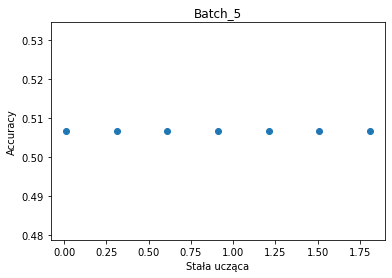

In [9]:
# mozemy jeszcze rozwazyc wykresy losses od eta. albo accuracy od ety 
# kroswalidacja 5-cio krotna, gradient descent
skf = StratifiedKFold(n_splits=5, shuffle=True)
id = 1
nr_zbioru = 1
eta = np.arange(0.01, 2, 0.3)
# accuracy_gd_1_eta = []
# accuracy_sgd_1_eta = []
# accuracy_batch_1_eta = []
# accuracy_iwls_1_eta = []
#plt.figure(figsize=(15, 5))
for train_index, test_index in skf.split(X_1, y_1):
    X_train, X_test = X_1[train_index], X_1[test_index]
    y_train, y_test = y_1[train_index], y_1[test_index]
    
    SC = StandardScaler()
    X_train = SC.fit_transform(X_train)
    X_test = SC.transform(X_test)
    
    # mamy dane po preprocesingu, dla kazdej pary train, test liczymy dokladnosc, tworzymy wykres strata od iteracji
    plt.figure()
    gradient_eta(X_train, y_train, X_test, y_test, id, nr_zbioru, eta)
    
    plt.figure()
    stochastic_gradient_eta(X_train, y_train, X_test, y_test, id, nr_zbioru, eta)
    
    plt.figure()
    batch_stochastic_gradient_eta(X_train, y_train, X_test, y_test, id, nr_zbioru, eta)
    
#     plt.figure()
#     IWLS_gradient_eta(X_train, y_train, X_test, y_test, id, nr_zbioru, eta)
    
    
    id += 1
# print(accuracy_gd_1_eta)
# print(accuracy_sgd_1_eta)
# print(accuracy_batch_1_eta)
# print(accuracy_iwls_1_eta)

### Zbiór danych nr 2

In [12]:

blood_transfusion_service_center = fetch_ucirepo(id=176) 
  
X_2 = blood_transfusion_service_center.data.features.values 
y_2 = blood_transfusion_service_center.data.targets
y_2 = y_2.values


In [16]:
X_2 = pd.DataFrame(X_2)
print(X_2.isna().sum())
corr_matrix = X_2.corr().abs()
sol = (corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
                  .stack()
                  .sort_values(ascending=False))
print(sol[0:8])
X_2 = X_2.drop(2, axis=1)
X_2 = X_2.values 

0    0
1    0
2    0
3    0
dtype: int64
1  2    1.000000
   3    0.634940
2  3    0.634940
0  2    0.182745
   1    0.182745
   3    0.160618
dtype: float64


[0.5511695906432749, 0.5482456140350878, 0.722953216374269, 0.5805764411027569, 0.6452380952380953]
[0.5665204678362573, 0.5431286549707602, 0.5416666666666666, 0.5098997493734335, 0.5868421052631579]
[0.5, 0.5, 0.4956140350877193, 0.5, 0.5660401002506266]
[0.5380116959064327, 0.5431286549707602, 0.5416666666666666, 0.5209273182957393, 0.5714285714285714]


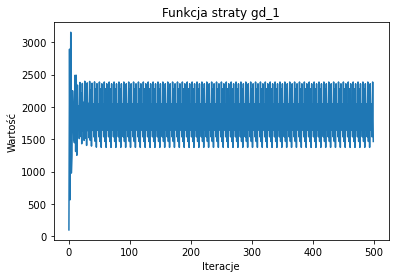

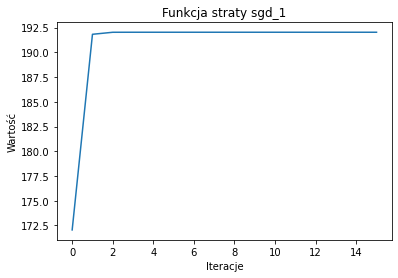

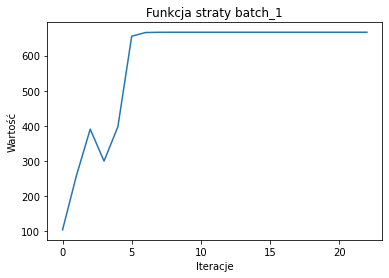

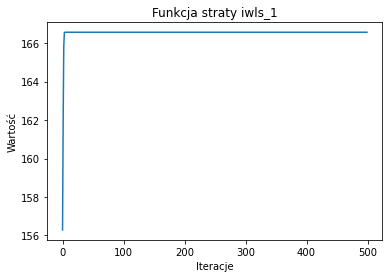

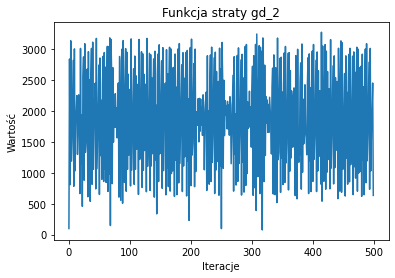

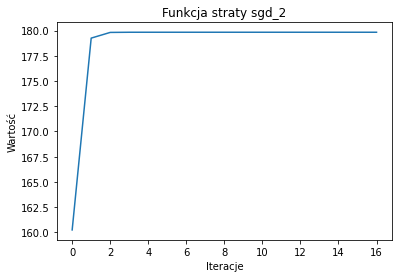

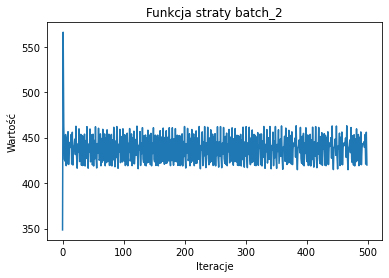

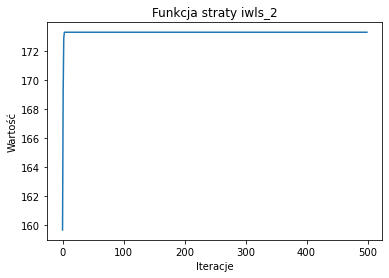

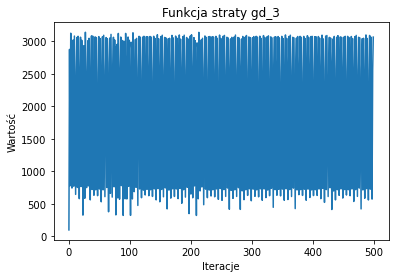

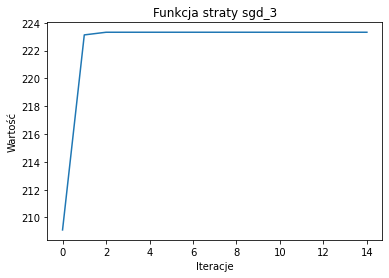

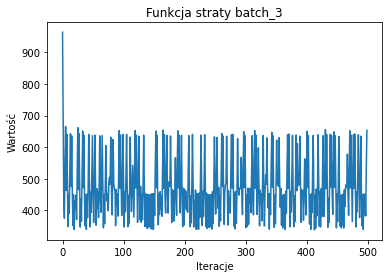

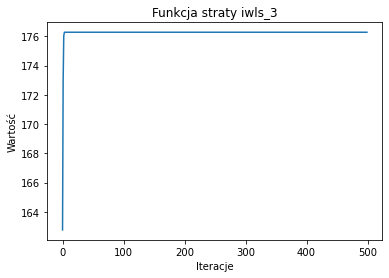

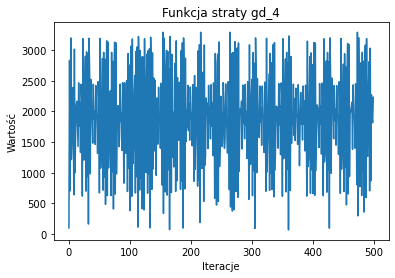

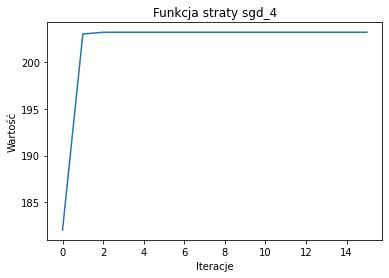

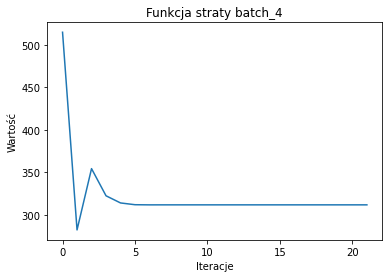

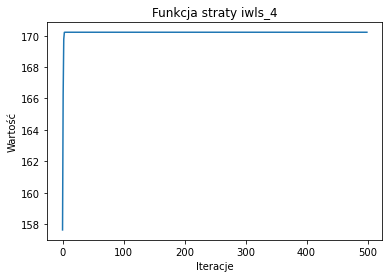

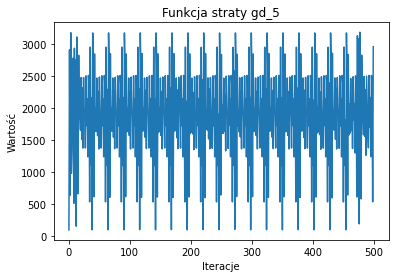

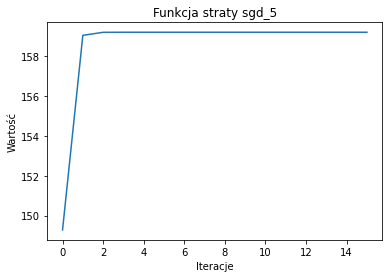

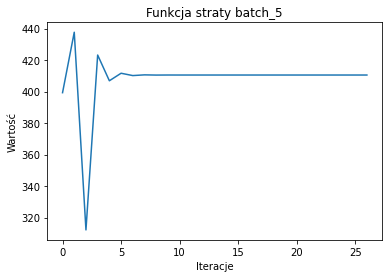

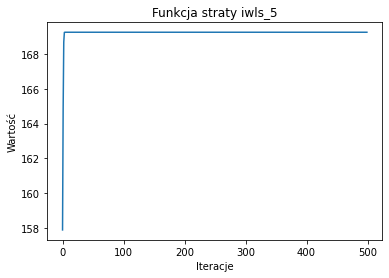

In [17]:
# kroswalidacja 5-cio krotna, gradient descent
skf = StratifiedKFold(n_splits=5, shuffle=True)
id = 1
nr_zbioru = 2
accuracy_gd_2 = []
accuracy_sgd_2 = []
accuracy_batch_2 = []
accuracy_iwls_2 = []
#plt.figure(figsize=(15, 5))
for train_index, test_index in skf.split(X_2, y_2):
    X_train, X_test = X_2[train_index], X_2[test_index]
    y_train, y_test = y_2[train_index], y_2[test_index]
    
    SC = StandardScaler()
    X_train = SC.fit_transform(X_train)
    X_test = SC.transform(X_test)
    
    # mamy dane po preprocesingu, dla kazdej pary train, test liczymy dokladnosc, tworzymy wykres strata od iteracji
    plt.figure()
    res1 = gradient(X_train, y_train, X_test, y_test, id, nr_zbioru)
    accuracy_gd_2.append(res1)
    plt.figure()
    res2 = stochastic_gradient(X_train, y_train, X_test, y_test, id, nr_zbioru)
    accuracy_sgd_2.append(res2)
    plt.figure()
    res3 = batch_stochastic_gradient(X_train, y_train, X_test, y_test, id, nr_zbioru)
    accuracy_batch_2.append(res3)
    plt.figure()
    res4 = IWLS_gradient(X_train, y_train, X_test, y_test, id, nr_zbioru)
    accuracy_iwls_2.append(res4)
    
    id += 1
print(accuracy_gd_2)
print(accuracy_sgd_2)
print(accuracy_batch_2)
print(accuracy_iwls_2)

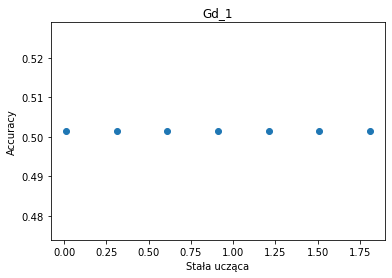

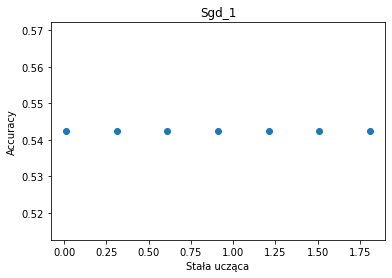

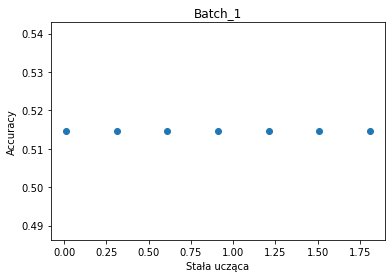

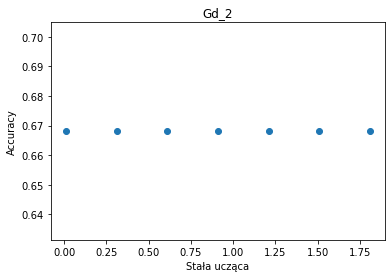

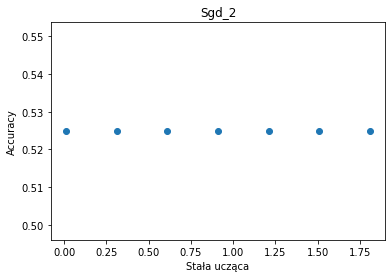

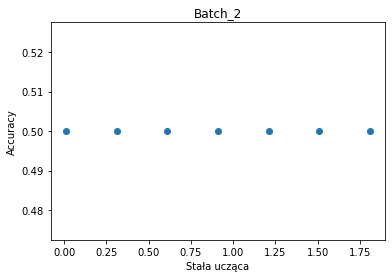

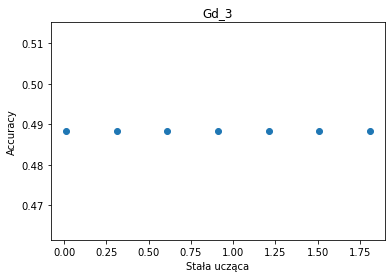

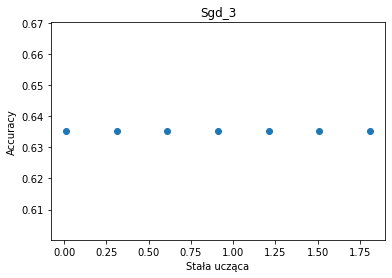

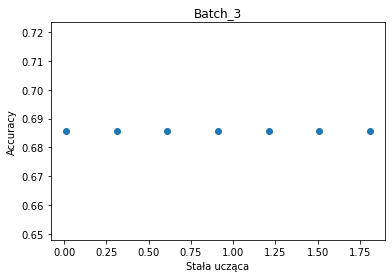

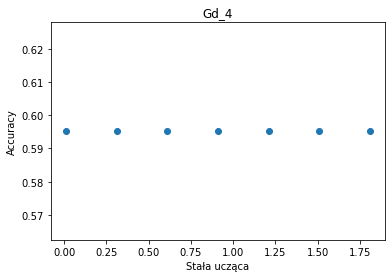

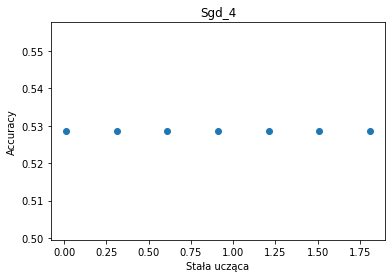

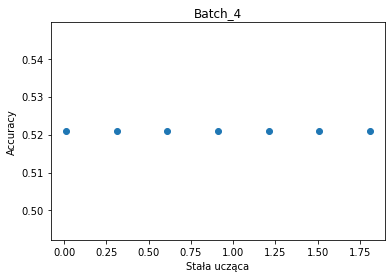

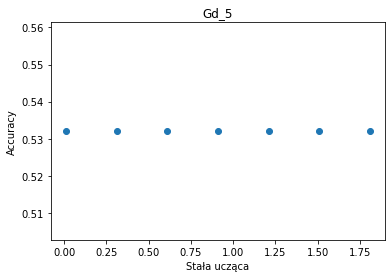

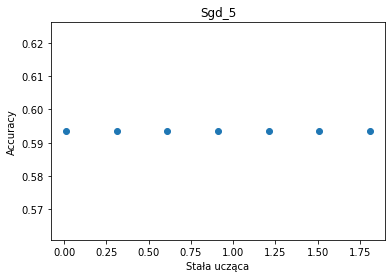

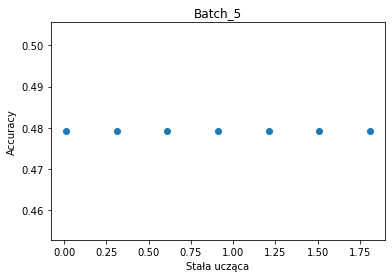

In [28]:
# mozemy jeszcze rozwazyc wykresy losses od eta. albo accuracy od ety 
# kroswalidacja 5-cio krotna, gradient descent
skf = StratifiedKFold(n_splits=5, shuffle=True)
id = 1
nr_zbioru = 2
eta = np.arange(0.01, 2, 0.3)
# accuracy_gd_1_eta = []
# accuracy_sgd_1_eta = []
# accuracy_batch_1_eta = []
# accuracy_iwls_1_eta = []
#plt.figure(figsize=(15, 5))
for train_index, test_index in skf.split(X_2, y_2):
    X_train, X_test = X_2[train_index], X_2[test_index]
    y_train, y_test = y_2[train_index], y_2[test_index]
    
    SC = StandardScaler()
    X_train = SC.fit_transform(X_train)
    X_test = SC.transform(X_test)
    
    # mamy dane po preprocesingu, dla kazdej pary train, test liczymy dokladnosc, tworzymy wykres strata od iteracji
    plt.figure()
    gradient_eta(X_train, y_train, X_test, y_test, id, nr_zbioru, eta)
    
    plt.figure()
    stochastic_gradient_eta(X_train, y_train, X_test, y_test, id, nr_zbioru, eta)
    
    plt.figure()
    batch_stochastic_gradient_eta(X_train, y_train, X_test, y_test, id, nr_zbioru, eta)
    
#     plt.figure()
#     IWLS_gradient_eta(X_train, y_train, X_test, y_test, id, nr_zbioru, eta)
    
    
    id += 1
# print(accuracy_gd_1_eta)
# print(accuracy_sgd_1_eta)
# print(accuracy_batch_1_eta)
# print(accuracy_iwls_1_eta)

### Zbiór danych nr 3

In [14]:
df = fetch_openml(data_id=1504) 

X_3 = df.data.values 
y_3 = df.target.values
y_3 = np.array([1 if znak == '2' else 0 for znak in y_3])

In [15]:
pd.DataFrame(X_3)

,0,1,2,3,4,5,6,7,8,9,...,23,24,25,26,27,28,29,30,31,32
0,42.0,50.0,270900.0,270944.0,267.0,17.0,44.0,24220.0,76.0,108.0,...,1.6435,0.8182,-0.2913,0.5822,1.0,0.0,0.0,0.0,0.0,0.0
1,645.0,651.0,2538079.0,2538108.0,108.0,10.0,30.0,11397.0,84.0,123.0,...,1.4624,0.7931,-0.1756,0.2984,1.0,0.0,0.0,0.0,0.0,0.0
2,829.0,835.0,1553913.0,1553931.0,71.0,8.0,19.0,7972.0,99.0,125.0,...,1.2553,0.6667,-0.1228,0.2150,1.0,0.0,0.0,0.0,0.0,0.0
3,853.0,860.0,369370.0,369415.0,176.0,13.0,45.0,18996.0,99.0,126.0,...,1.6532,0.8444,-0.1568,0.5212,1.0,0.0,0.0,0.0,0.0,0.0
4,1289.0,1306.0,498078.0,498335.0,2409.0,60.0,260.0,246930.0,37.0,126.0,...,2.4099,0.9338,-0.1992,1.0000,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1936,249.0,277.0,325780.0,325796.0,273.0,54.0,22.0,35033.0,119.0,141.0,...,1.2041,-0.4286,0.0026,0.7254,0.0,0.0,0.0,0.0,0.0,0.0
1937,144.0,175.0,340581.0,340598.0,287.0,44.0,24.0,34599.0,112.0,133.0,...,1.2305,-0.4516,-0.0582,0.8173,0.0,0.0,0.0,0.0,0.0,0.0
1938,145.0,174.0,386779.0,386794.0,292.0,40.0,22.0,37572.0,120.0,140.0,...,1.1761,-0.4828,0.0052,0.7079,0.0,0.0,0.0,0.0,0.0,0.0
1939,137.0,170.0,422497.0,422528.0,419.0,97.0,47.0,52715.0,117.0,140.0,...,1.4914,-0.0606,-0.0171,0.9919,0.0,0.0,0.0,0.0,0.0,0.0


In [19]:
#y = pd.DataFrame(y_3)
#y[0].value_counts()
#pd.DataFrame(X_3)

In [20]:
X_3 = pd.DataFrame(X_3)
print(X_3.isna().sum())
corr_matrix = X_3.corr().abs()
sol = (corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
                  .stack()
                  .sort_values(ascending=False))
print(sol[0:8])
X_3 = X_3.drop([12, 3, 1 ,4] , axis=1)
X_3 = X_3.values

0     0
1     0
2     0
3     0
4     0
5     0
6     0
7     0
8     0
9     0
10    0
11    0
12    0
13    0
14    0
15    0
16    0
17    0
18    0
19    0
20    0
21    0
22    0
23    0
24    0
25    0
26    0
27    0
28    0
29    0
30    0
31    0
32    0
dtype: int64
11  12    1.000000
2   3     1.000000
0   1     0.988314
4   7     0.978952
    5     0.966644
5   7     0.912956
    6     0.912436
21  22    0.888919
dtype: float64


[0.9925925925925926, 1.0, 0.9776119402985075, 0.994320011711316, 1.0]
[1.0, 1.0, 0.9925373134328358, 1.0, 1.0]
[0.9980314960629921, 1.0, 0.9925373134328358, 1.0, 0.9980237154150198]
[1.0, 1.0, 1.0, 1.0, 0.9980237154150198]


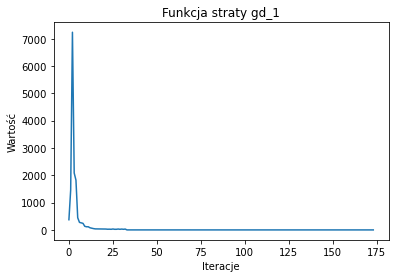

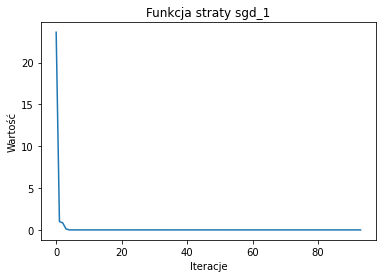

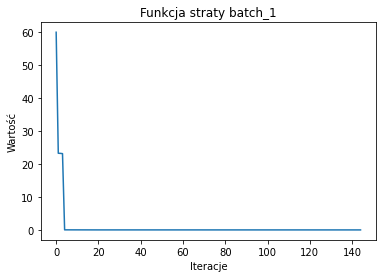

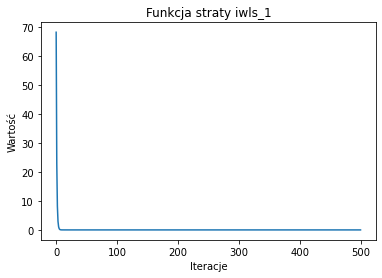

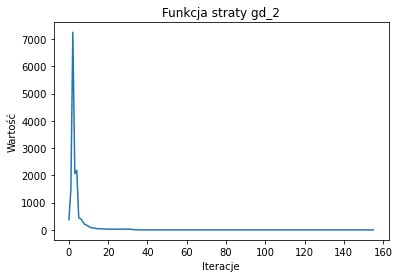

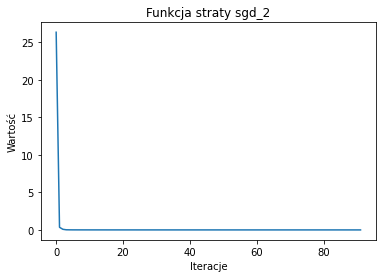

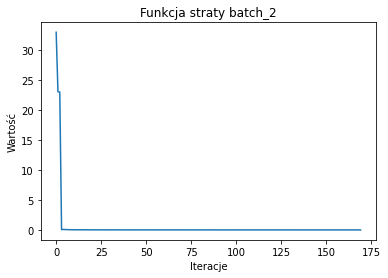

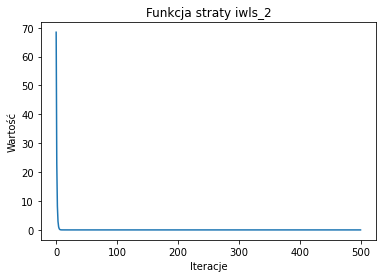

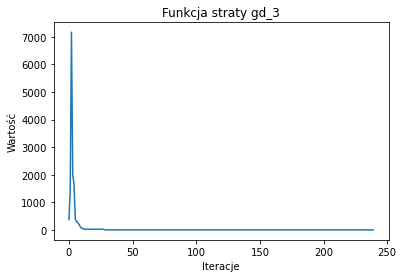

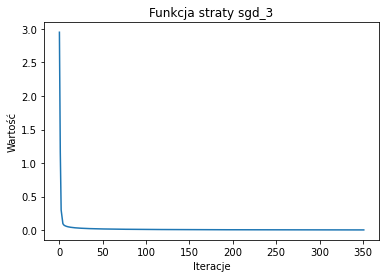

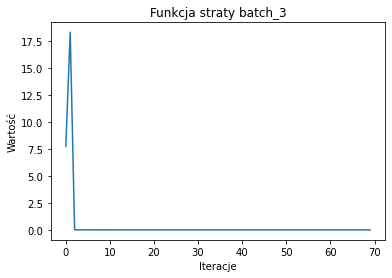

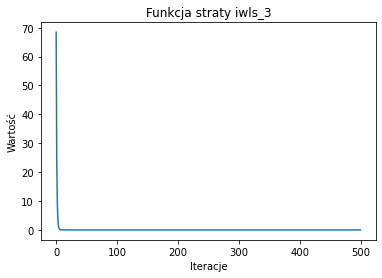

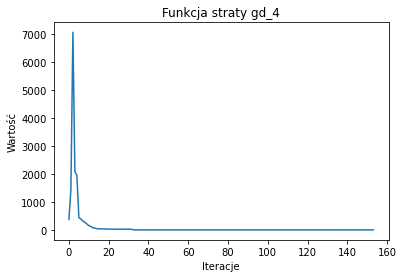

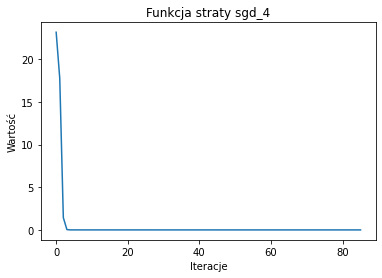

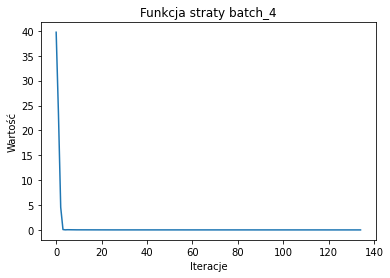

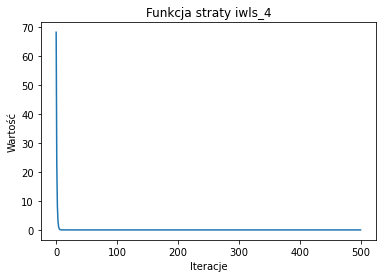

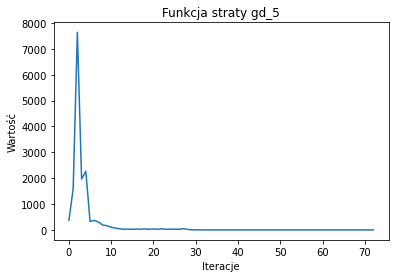

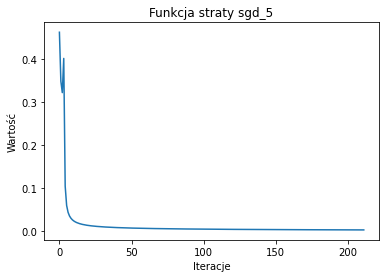

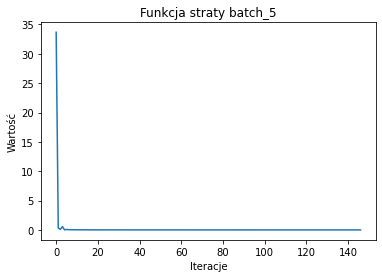

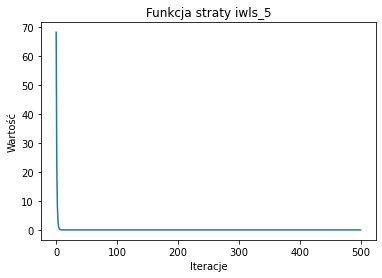

In [21]:
# kroswalidacja 5-cio krotna, gradient descent
skf = StratifiedKFold(n_splits=5, shuffle=True)
id = 1
nr_zbioru = 3
accuracy_gd_3 = []
accuracy_sgd_3 = []
accuracy_batch_3 = []
accuracy_iwls_3 = []
#plt.figure(figsize=(15, 5))
for train_index, test_index in skf.split(X_3, y_3):
    X_train, X_test = X_3[train_index], X_3[test_index]
    y_train, y_test = y_3[train_index], y_3[test_index]
    
    SC = StandardScaler()
    X_train = SC.fit_transform(X_train)
    X_test = SC.transform(X_test)
    
    # mamy dane po preprocesingu, dla kazdej pary train, test liczymy dokladnosc, tworzymy wykres strata od iteracji
    plt.figure()
    res1 = gradient(X_train, y_train, X_test, y_test, id, nr_zbioru)
    accuracy_gd_3.append(res1)
    plt.figure()
    res2 = stochastic_gradient(X_train, y_train, X_test, y_test, id, nr_zbioru)
    accuracy_sgd_3.append(res2)
    plt.figure()
    res3 = batch_stochastic_gradient(X_train, y_train, X_test, y_test, id, nr_zbioru)
    accuracy_batch_3.append(res3)
    plt.figure()
    res4 = IWLS_gradient(X_train, y_train, X_test, y_test, id, nr_zbioru)
    accuracy_iwls_3.append(res4)
    
    id += 1
print(accuracy_gd_3)
print(accuracy_sgd_3)
print(accuracy_batch_3)
print(accuracy_iwls_3)

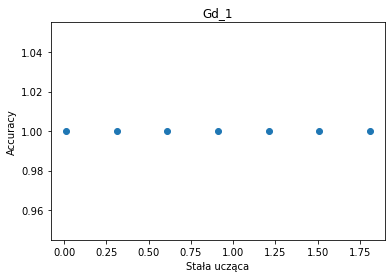

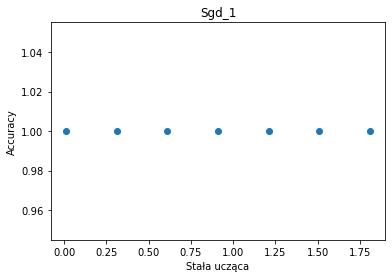

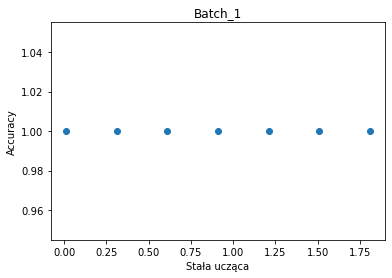

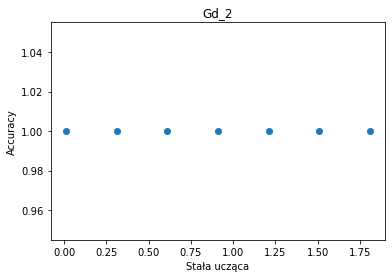

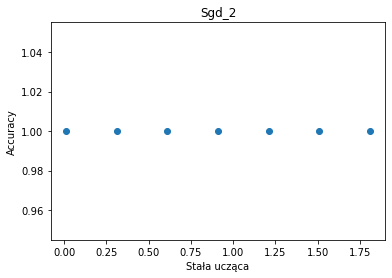

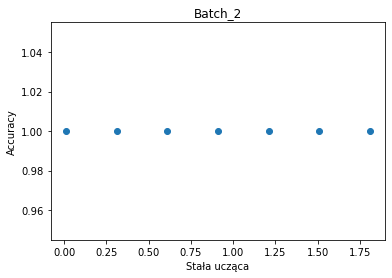

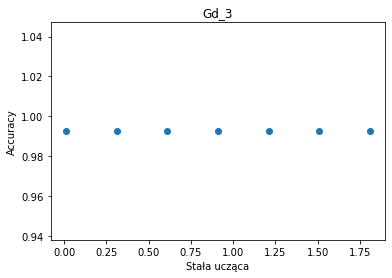

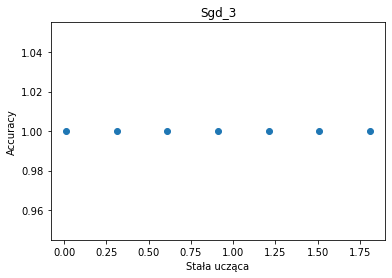

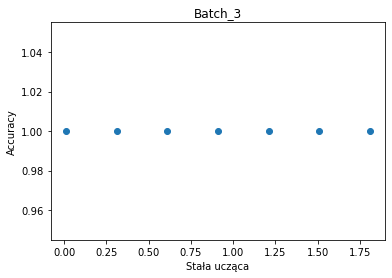

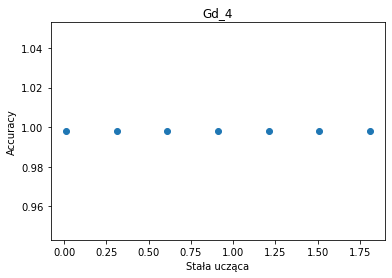

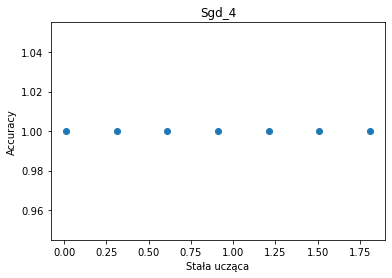

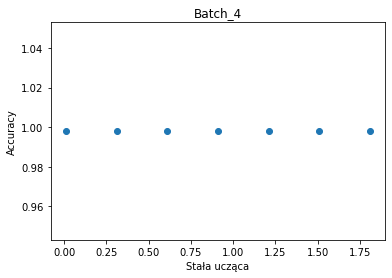

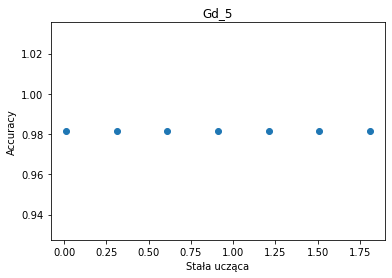

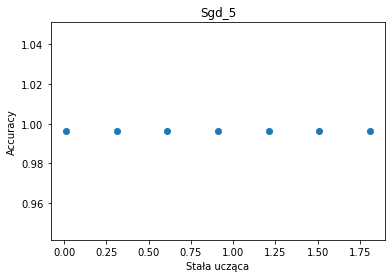

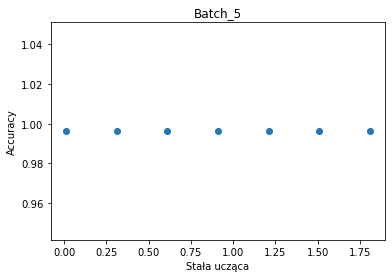

In [29]:
# mozemy jeszcze rozwazyc wykresy losses od eta. albo accuracy od ety 
# kroswalidacja 5-cio krotna, gradient descent
skf = StratifiedKFold(n_splits=5, shuffle=True)
id = 1
nr_zbioru = 3
eta = np.arange(0.01, 2, 0.3)

for train_index, test_index in skf.split(X_3, y_3):
    X_train, X_test = X_3[train_index], X_3[test_index]
    y_train, y_test = y_3[train_index], y_3[test_index]
    
    SC = StandardScaler()
    X_train = SC.fit_transform(X_train)
    X_test = SC.transform(X_test)
    
    # mamy dane po preprocesingu, dla kazdej pary train, test liczymy dokladnosc, tworzymy wykres strata od iteracji
    plt.figure()
    gradient_eta(X_train, y_train, X_test, y_test, id, nr_zbioru, eta)
    
    plt.figure()
    stochastic_gradient_eta(X_train, y_train, X_test, y_test, id, nr_zbioru, eta)
    
    plt.figure()
    batch_stochastic_gradient_eta(X_train, y_train, X_test, y_test, id, nr_zbioru, eta)      
    
    id += 1


In [26]:
# Srednie accuracy dla poszczegolnych algorytmow
table_accuracy = []
# dla gd
table_accuracy.append((sum(accuracy_gd_1) + sum(accuracy_gd_2) + sum(accuracy_gd_3) ) / 15)
# dla sgd
table_accuracy.append((sum(accuracy_sgd_1) + sum(accuracy_sgd_2) + sum(accuracy_sgd_3) ) / 15)
# dla sgd_batch
table_accuracy.append((sum(accuracy_batch_1) + sum(accuracy_batch_2) + sum(accuracy_batch_3) ) / 15)
# dla IWLS
table_accuracy.append((sum(accuracy_iwls_1) + sum(accuracy_iwls_2) + sum(accuracy_iwls_3) ) / 15)
print(table_accuracy)

[0.7871352035197909, 0.7146590040454093, 0.7012746731147037, 0.7354508293404624]


In [27]:
set_accuracy = []
# dla set 1
set_accuracy.append((sum(accuracy_gd_1) + sum(accuracy_sgd_1) + sum(accuracy_batch_1) + sum(accuracy_iwls_1) ) / 20)
# dla set 2
set_accuracy.append((sum(accuracy_gd_2) + sum(accuracy_sgd_2) + sum(accuracy_batch_2) + sum(accuracy_iwls_2) ) / 20)
# dla set 3
set_accuracy.append((sum(accuracy_gd_3) + sum(accuracy_sgd_3) + sum(accuracy_batch_3) + sum(accuracy_iwls_3) ) / 20)
print(set_accuracy)

[0.653052995391705, 0.5536528822055138, 0.997183904918056]
